In [1]:
import numpy as np
import scipy
from scipy.stats import qmc
import matplotlib.pyplot as plt
import ctypes
import math
import random
from tqdm.notebook import trange

In [2]:
from design_criteria import wd2, cl2, Mm, phip, maxPro, latinize, evaluate

In [3]:
import ctypes
import platform

lib_name = "./maxpro.dll" if platform.system() == "Windows" else "./maxpro.so"
cppfn = ctypes.CDLL(lib_name)


cppfn.maxpro_design_meshgrid.argtypes = (
    ctypes.c_int, # nv
    ctypes.c_int, # ns
    ctypes.c_int, # seed
    ctypes.c_bool, # periodic
    ctypes.c_bool, # rand_ini
    ctypes.c_bool # rand_sel
)
cppfn.maxpro_design_meshgrid.restype = ctypes.POINTER(ctypes.c_int)

def maxpro_design_meshgrid(nv, ns, seed = None, periodic = True, rand_ini = True, rand_sel = True):
    global cppfn
    pointer = cppfn.maxpro_design_meshgrid(nv, ns, random.randrange(2 ** 31) if seed == None else seed, periodic, rand_ini, rand_sel)
    return np.ctypeslib.as_array(pointer, (ns, nv))


cppfn.gen_design_candidates.argtypes = (
    ctypes.c_char, # crit
    ctypes.c_int, # nv
    ctypes.c_int, # ns
    ctypes.c_longlong, # candidate_count
    ctypes.POINTER(ctypes.c_double), # candidates
    ctypes.c_int, # seed
    ctypes.c_bool, # periodic
    ctypes.c_bool # rand_sel
)

def gen_design_candidates(crit, nv, ns, seed = None, candidate_count = None, candidate_method = "monte-carlo", periodic = True, rand_sel = True):
    global cppfn
    if candidate_count == None: # Auto
        #candidate_count = min(16 ** nv * ns, 1024 ** 3 // nv) # 8 GB RAM limit for candidates
        candidate_count = min(10000 * ns, 1024 ** 3 // nv) # 8 GB RAM limit for candidates
    match candidate_method:
        case "monte-carlo":
            candidates = np.ascontiguousarray(np.random.rand(candidate_count, nv))
        case "meshgriddy":
            candidate_count = ns ** nv
            candidates = np.empty([ns] * nv + [nv])
            for v in range(nv):
                candidates[tuple(([slice(None)] * nv) + [v])] = ((np.arange(ns) + 0.5) / ns)[tuple(([np.newaxis] * v) + [slice(None)] + ([np.newaxis] * (nv - v - 1)))]
            candidates.shape = [ns ** nv, nv]
            candidates = np.ascontiguousarray(candidates)
        case default:
            raise ValueError("Unknown candidate method: \"" + candidate_method + "\"")
    match crit:
        case "maxpro":
            cppfn.gen_design_candidates(b'm', nv, ns, candidate_count, candidates.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), random.randrange(2 ** 31) if seed == None else seed, periodic, rand_sel)
        case "phim":
            cppfn.gen_design_candidates(b'p', nv, ns, candidate_count, candidates.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), random.randrange(2 ** 31) if seed == None else seed, periodic, rand_sel)
        case "maximin":
            cppfn.gen_design_candidates(b'M', nv, ns, candidate_count, candidates.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), random.randrange(2 ** 31) if seed == None else seed, periodic, rand_sel)
    return candidates[:ns, :]

In [4]:
nv = 2
ns = 164


# Additive designs
periodic = True
rand_ini = True
rand_sel = False

# qmc
scramble = False 

In [5]:
class Design:
    name: str
    points: np.ndarray
    maxpro: float
    umaxpro: float
    maximin_nper: float
    maximin: float
    discr: float
    phip: float
    pphip: float
    wd2: float
    cl2: float

    def comp_stats(self):
        self.maxpro = maxPro(self.points, False)
        self.umaxpro = maxPro(self.points, True)
        self.maximin = Mm(self.points, False)
        self.pmaximin = Mm(self.points, True)
        self.phip = phip(self.points, False)
        self.pphip = phip(self.points, True)
        self.wd2 = wd2(self.points)
        self.cl2 = cl2(self.points)
        self.mdiscr = scipy.stats.qmc.discrepancy(self.points, method='MD' ) 
        self.l2stardiscr = scipy.stats.qmc.discrepancy(self.points, method='L2-star' ) 
        #CD: Centered Discrepancy - subspace involves a corner of the hypercube
        #WD: Wrap-around Discrepancy - subspace can wrap around bounds
        #MD: Mixture Discrepancy - mix between CD/WD covering more criteria
        #L2-star: L2-star discrepancy - like CD BUT variant to rotatio

    def __init__(self, points, name):
        self.name = name
        self.points = points
        self.comp_stats()

METHODS = [
    "as_maxpro", # Adaptive sampling; already latinized
    "as_phim",
    "as_maximin",
    "mg_maxpro", # Meshgrid
    "qmc_sobol", # Quasi Monte Carlo; already latinized
    "qmc_halton"
]

designs = dict()

In [6]:
%%time
designs["mg_maxpro"] = Design(
    (maxpro_design_meshgrid(nv, ns, periodic = periodic, rand_ini = rand_ini, rand_sel = rand_sel).astype(float) + 0.5) / ns,
    "mg_maxpro"
)

CPU times: total: 15.6 ms
Wall time: 14 ms


In [7]:
%%time
designs["as_maxpro"] = Design(
    latinize(gen_design_candidates("maxpro", nv, ns, candidate_method = "monte-carlo", periodic = periodic, rand_sel = rand_sel)),
    "as_maxpro",
)

CPU times: total: 2.38 s
Wall time: 2.44 s


In [8]:
%%time
designs["as_phim"] = Design(
    latinize(gen_design_candidates("phim", nv, ns, candidate_method = "monte-carlo", periodic = periodic, rand_sel = rand_sel)),
    "as_maxpro",
)

CPU times: total: 2.72 s
Wall time: 2.73 s


In [9]:
%%time
designs["as_maximin"] = Design(
    (gen_design_candidates("maximin", nv, ns, candidate_method = "monte-carlo", periodic = periodic, rand_sel = rand_sel)),
    "as_maxpro",
)

CPU times: total: 2.55 s
Wall time: 2.6 s


In [10]:
%%time
sobol_sampler = qmc.Sobol(d = nv, scramble = scramble)
sobol_points = sobol_sampler.random(ns)
sobol_points -= sobol_points.min()
sobol_points += 0.5 * (1 - sobol_points.max())
designs["qmc_sobol"] = Design(latinize(sobol_points), "qmc_sobol")

CPU times: total: 31.2 ms
Wall time: 23.3 ms


c:\Users\vorec\anaconda3\envs\tensor\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [11]:
%%time
halton_sampler = qmc.Halton(d = nv, scramble = scramble)
halton_points = halton_sampler.random(ns)
halton_points -= halton_points.min()
halton_points += 0.5 * (1 - halton_points.max())
designs["qmc_halton"] = Design(latinize(halton_points), "qmc_halton")

CPU times: total: 15.6 ms
Wall time: 12 ms


In [12]:
best_maxpro = math.inf
best_umaxpro = math.inf
best_maximin = 0
best_pmaximin = 0
best_mdiscr = math.inf
best_phip = math.inf
best_pphip = math.inf
best_cl2 = math.inf
best_wd2 = math.inf

for method in METHODS:
    best_maxpro = min(best_maxpro, designs[method].maxpro)
    best_umaxpro = min(best_umaxpro, designs[method].umaxpro)
    best_maximin = max(best_maximin, designs[method].maximin)
    best_pmaximin = max(best_pmaximin, designs[method].pmaximin)
    best_mdiscr = min(best_mdiscr, designs[method].mdiscr)
    best_phip = min(best_phip, designs[method].phip)
    best_pphip = min(best_pphip, designs[method].pphip)
    best_cl2 = min(best_cl2, designs[method].cl2)
    best_wd2 = min(best_wd2, designs[method].wd2)

CELL_WIDTH = 25
print((("+" + ("-" * (CELL_WIDTH-1))) * 10) + "+")
print("| name\t| MaxPro\t| uMaxPro\t| maximin\t| pmaximin\t| mixed discrepancy\t| phip\t| pphip\t| cl2\t| wd2\t|".expandtabs(CELL_WIDTH))
print("=" * CELL_WIDTH * 10 + "=")
for i, method in enumerate(METHODS):
    print((
        "| " +
        method +
        "\t| " +
        str(designs[method].maxpro / best_maxpro) +
        "\t| " +
        str(designs[method].umaxpro / best_umaxpro) +
        "\t| " +
        str(best_maximin / designs[method].maximin) +
        "\t| " +
        str(best_pmaximin / designs[method].pmaximin) +
        "\t| " +
        str(designs[method].mdiscr / best_mdiscr) +
        "\t| " +
        str(designs[method].phip / best_phip) +
        "\t| " +
        str(designs[method].pphip / best_pphip) +
        "\t| " +
        str(designs[method].cl2 / best_cl2) +
        "\t| " +
        str(designs[method].wd2 / best_wd2) +
        "\t|"
    ).expandtabs(CELL_WIDTH))
    print((("+" + ("-" * (CELL_WIDTH-1))) * 10) + "+")

print("\n\n\n\n")
    
print((("+" + ("-" * (CELL_WIDTH-1))) * 10) + "+")
print("| name\t| MaxPro\t| uMaxPro\t| maximin\t| pmaximin\t| mixed discrepancy\t| phip\t| pphip\t| cl2\t| wd2\t|".expandtabs(CELL_WIDTH))
print("=" * CELL_WIDTH * 10 + "=")
for i, method in enumerate(METHODS):
    print((
        "| " +
        method +
        "\t| " +
        str(designs[method].maxpro) +
        "\t| " +
        str(designs[method].umaxpro) +
        "\t| " +
        str(designs[method].maximin) +
        "\t| " +
        str(designs[method].pmaximin) +
        "\t| " +
        str(designs[method].mdiscr) +
        "\t| " +
        str(designs[method].phip) +
        "\t| " +
        str(designs[method].pphip) +
        "\t| " +
        str(designs[method].cl2) +
        "\t| " +
        str(designs[method].wd2) +
        "\t|"
    ).expandtabs(CELL_WIDTH))
    print((("+" + ("-" * (CELL_WIDTH-1))) * 10) + "+")

+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+
| name                   | MaxPro                 | uMaxPro                | maximin                | pmaximin               | mixed discrepancy      | phip                   | pphip                  | cl2                    | wd2                    |
| as_maxpro              | 1.0                    | 1.0                    | 1.5219086863203553     | 1.5218836270442728     | 1.0                    | 1.0208628933822013     | 1.0199536568677867     | 1.3076044976984138     | 1.0                    |
+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------

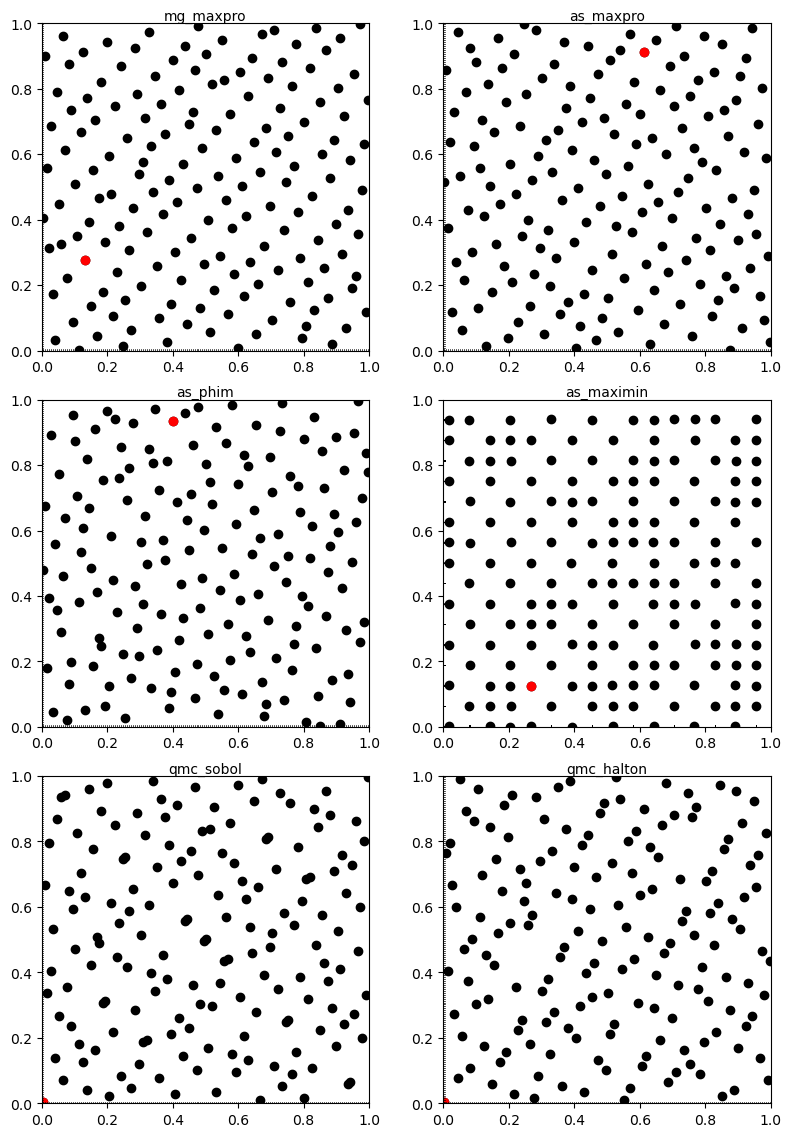

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_des(ax, des, name, color='k', alpha=1):
    ax.scatter(des[:, -2], des[:, -1], color=color, alpha=alpha)
    ax.scatter(des[0, -2], des[0, -1], color="red", alpha=alpha)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.set_title(name, fontsize=10, pad=2)
    
    tick_length = 0.005
    for x in des[:, 0]:
        ax.plot([x, x], [0, tick_length], color='black', linewidth=0.5, alpha=alpha)
    for y in des[:, 1]:
        ax.plot([0, tick_length], [y, y], color='black', linewidth=0.5, alpha=alpha)

# Calculate layout
num_designs = len(designs)
cols = 2
rows = math.ceil(num_designs / cols)

fig, axs = plt.subplots(
    rows, cols, figsize=(4 * cols, 4 * rows),
    gridspec_kw=dict(wspace=0.05, hspace=0.15)  # Tight spacing
)
axs = axs.flatten()


for pts in range (ns,ns+1):
    for i, (name, design) in enumerate(designs.items()):
        plot_des(axs[i], design.points[:pts,:], name)

    # Turn off any unused axes
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.05)
    plt.show()



In [19]:
nr = 10000
hist = np.zeros([ns] * nv, dtype=int)
for i in trange(nr):
    des = maxpro_design_meshgrid(nv, ns, seed=i, periodic = periodic, rand_ini = rand_ini, rand_sel = rand_sel)
    np.add.at(hist, (des[:, 0], des[:, 1]), 1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:
hist

array([[59, 54, 64, ..., 63, 57, 54],
       [64, 71, 59, ..., 48, 53, 49],
       [63, 64, 61, ..., 46, 46, 53],
       ...,
       [61, 65, 67, ..., 55, 50, 55],
       [77, 73, 56, ..., 55, 57, 65],
       [56, 61, 44, ..., 43, 68, 76]])

In [23]:
hist2 = hist.astype(float) / nr * ns
hist2

array([[0.9676, 0.8856, 1.0496, ..., 1.0332, 0.9348, 0.8856],
       [1.0496, 1.1644, 0.9676, ..., 0.7872, 0.8692, 0.8036],
       [1.0332, 1.0496, 1.0004, ..., 0.7544, 0.7544, 0.8692],
       ...,
       [1.0004, 1.066 , 1.0988, ..., 0.902 , 0.82  , 0.902 ],
       [1.2628, 1.1972, 0.9184, ..., 0.902 , 0.9348, 1.066 ],
       [0.9184, 1.0004, 0.7216, ..., 0.7052, 1.1152, 1.2464]])

In [24]:
symmetrize = True # to generate the additional designs from the existing ones

n_des = nr #number of designes packed into x_opt_all


freq = hist

print(f"Check that the no of data in bins {np.sum(freq)} matches the number of points {n_des*ns}\n")
print(f"\nNow the symmetrized histogram construction")

design_count_multiplier = 1
freq_s = freq.copy() # Stands for frequencies symmetrized (identical to `freq` if not symmetrizing)
if symmetrize:
    # Account for reordering the axes
    for set_v in range(nv - 1): # Note that this trange is going to speed up over time
        freq_copy = np.copy(freq_s) # Add to the `freq_s` array; this is for a reference to get all the distinct transposed versions of the original
        transpose_indices = list(range(nv))
        for swapped_v in range(set_v + 1, nv): # You would normally go from `set_v` + 0, but I am adding to an array equivalent to `swapped_v` = `set_v`
            transpose_indices[set_v], transpose_indices[swapped_v] = swapped_v, set_v
            freq_s += np.transpose(freq_copy, tuple(transpose_indices))
            transpose_indices[swapped_v] = swapped_v # Cleanup for next loop run
    
    # Mirror about every axis
    for v in range(nv):
        freq_s += np.flip(freq_s, axis=v)


    design_count_multiplier = (2 ** nv) * math.factorial(nv)
    print("Design count incerased ", design_count_multiplier," times from ",n_des, " to ", n_des * design_count_multiplier)
    
    print(f"Check that the no of data in bins {np.sum(freq_s)} matches the number of points {n_des*ns*design_count_multiplier}")

# Recompute frequencies into relative freq (ave density)
histogram = freq * ((ns ** (nv-1)) / n_des)
histogram_s = freq_s * ((ns ** (nv-1)) / n_des / design_count_multiplier)

print(f"\n")
print(f"Minimum density: {histogram.min()},  maximum density: {histogram.max()}, stdev of density: {histogram.std()}")



     

Check that the no of data in bins 1640000 matches the number of points 1640000


Now the symmetrized histogram construction
Design count incerased  8  times from  10000  to  80000
Check that the no of data in bins 13120000 matches the number of points 13120000


Minimum density: 0.5084000000000001,  maximum density: 1.6400000000000001, stdev of density: 0.14579547318075414


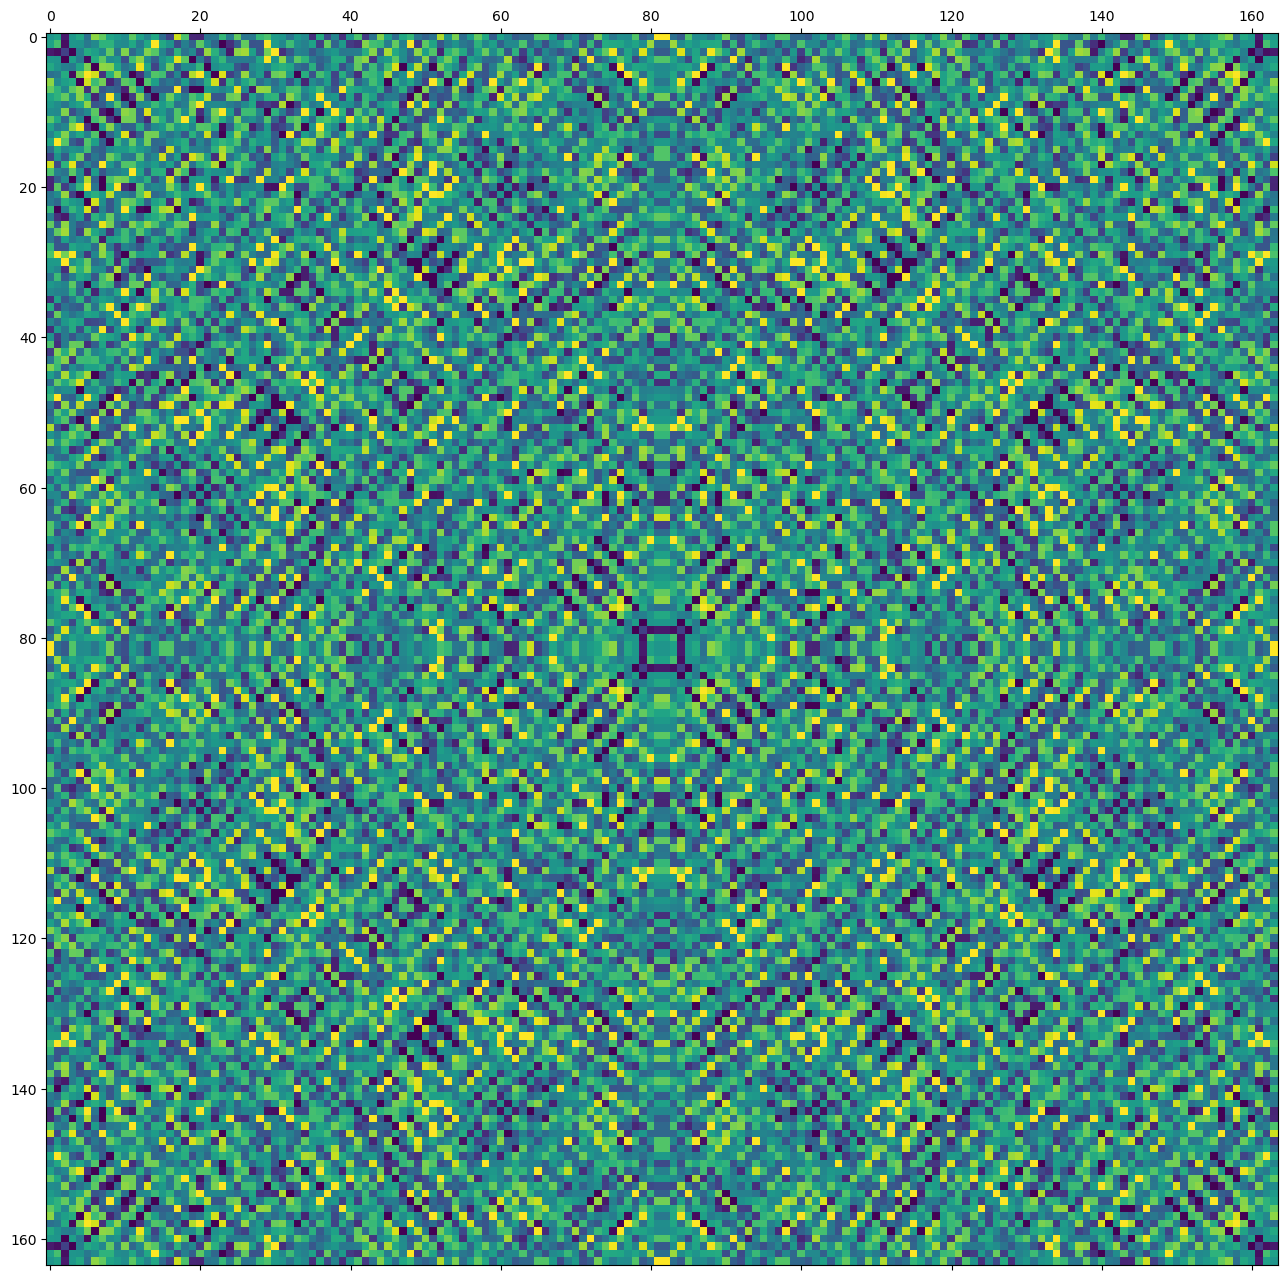

In [25]:
fig, ax = plt.subplots(figsize=(16, 16))

vmin, vmax = 0, 5

if periodic:
    vmin, vmax = 0.9, 1.1
    
ax.matshow(histogram_s, vmin=vmin, vmax=vmax)

plt.show()

In [37]:
n = 1

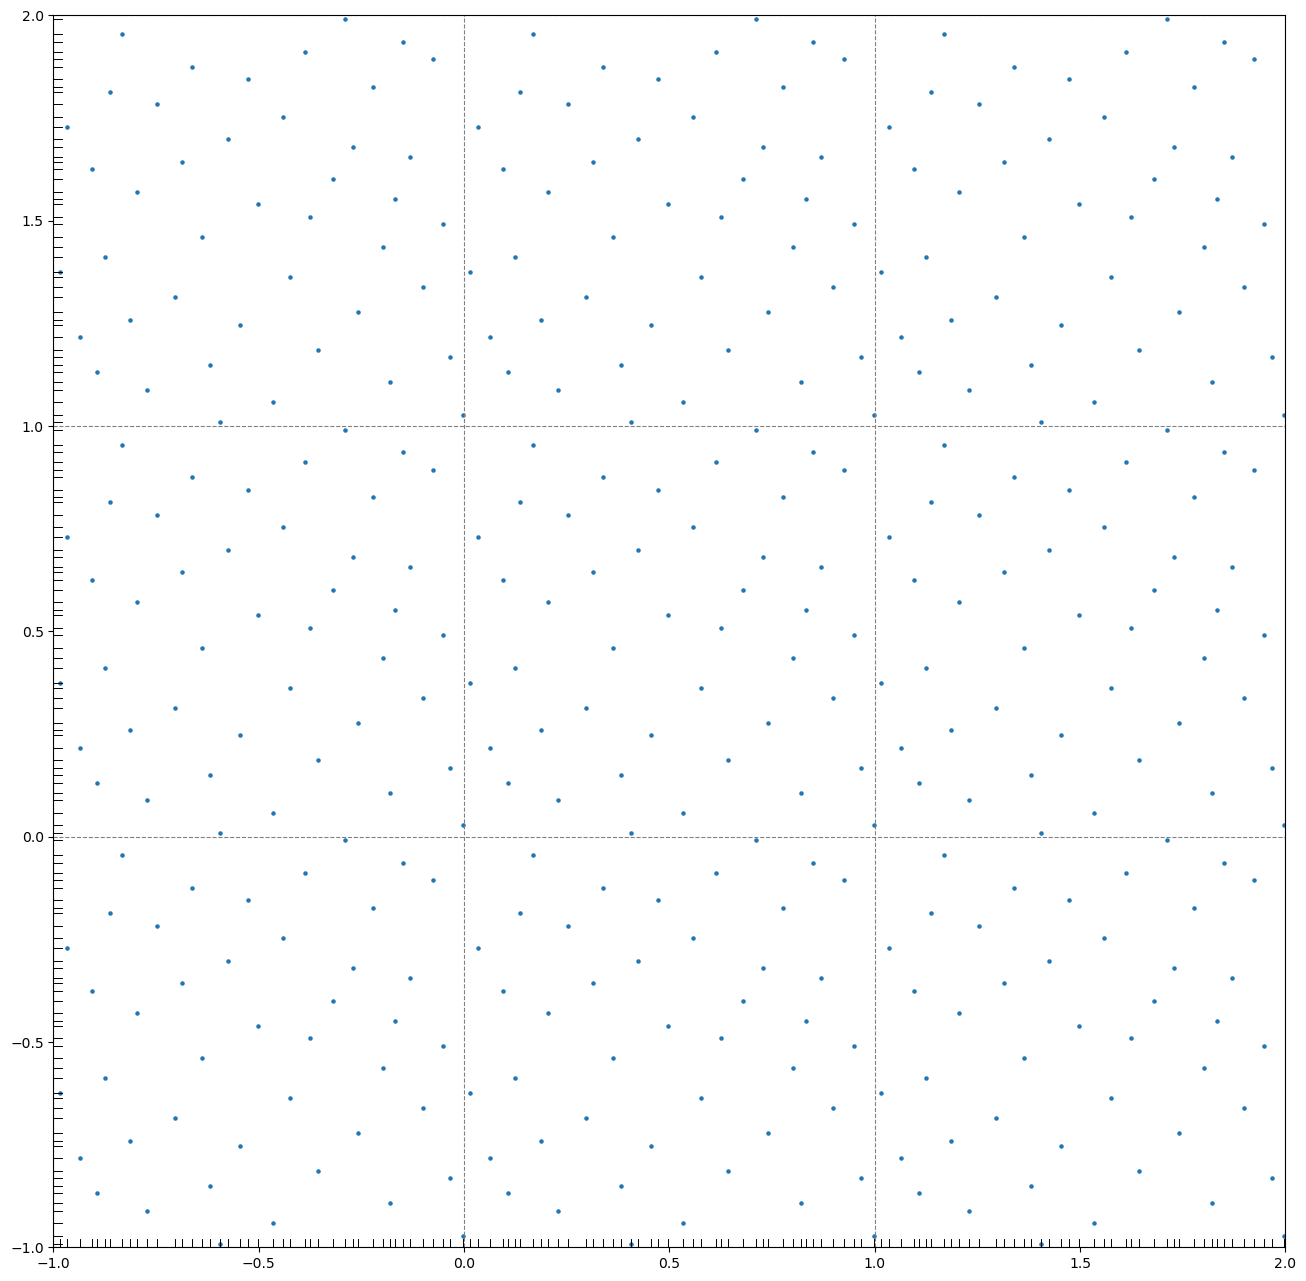

In [80]:
#pts = points[:, (0, 1)]
#pts = phimc[:n]

pts = designs["as_maxpro"].points[:n]
n += 1
# Assume pts is a (N, 2) NumPy array with values in [0, 1]
offsets = [-1, 0, 1]
tiled_points = []

for dx in offsets:
    for dy in offsets:
        shifted = pts + np.array([dx, dy])
        tiled_points.append(shifted)

tiled_points = np.vstack(tiled_points)

# Plot
fig, ax = plt.subplots(figsize=(16, 16))
ax.scatter(tiled_points[:, 0], tiled_points[:, 1], s=5)

# Set limits and aspect
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)
ax.set_aspect('equal')

# Tile boundary lines
for x in range(-1, 3):
    ax.axvline(x, color='gray', linestyle='--', linewidth=0.8)
for y in range(-1, 3):
    ax.axhline(y, color='gray', linestyle='--', linewidth=0.8)

# Add projections:
tick_length = 0.02  # Length of the projection lines

# Vertical ticks at bottom (y = -1)
for x in tiled_points[:, 0]:
    ax.plot([x, x], [-1, -1 + tick_length], color='black', linewidth=0.5)

# Horizontal ticks at left (x = -1)
for y in tiled_points[:, 1]:
    ax.plot([-1, -1 + tick_length], [y, y], color='black', linewidth=0.5)

plt.show()
